In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta, date
from pyrsktools import RSK

In [2]:
def read_rbr(filename):
    '''
    Reads data from a .rsk data file from a RBR logger (concerto, solo, ...).
    https://github.com/UNISvalbard/unisacsi/blob/main/unisacsi/Ocean.py#L1488
    Parameters:
    -------
    filename: str
        String with path to file
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''
    
    with RSK(filename) as rsk:
        rsk.readdata()
        rsk.deriveseapressure()
        variables = list(rsk.channelNames)
        time = pd.to_datetime(rsk.data["timestamp"])
        
        if "conductivity" in variables:
            rsk.derivesalinity()
            rsk.derivesigma()
            # variables.append("salinity")
            # variables.append("density")
        variables = list(rsk.channelNames)
        
        data = rsk.data[variables]
        
        df = pd.DataFrame(data, index=time, columns=variables)
        
        #df.rename({"condictivity": "C", "temperature": "T", "salinity": "S", "pressure": "P", "sea_pressure": "Ps", "density_anomaly": "SIGTH"}, axis=1, inplace=True)
        df.sort_index(axis=0, inplace=True)
        
    return df

In [ ]:
# Read RBR and VanEssen sensors
df_rbr = read_rbr(r"...\TD_230400_20250801_1925.rsk")

#df_diver = pd.read_csv(r"...\diver.csv", sep=',',index_col='Datetime', parse_dates=True)
df_baro = pd.read_csv(r"...\baro.csv", sep=',',index_col='Datetime', parse_dates=True)

# transform strings to floats
#df_diver.Temperature = (df_diver.Temperature.astype(str) + '.' + df_diver.Tdecimal.astype(str)).astype(float)
#df_diver.Pressure = (df_diver.Pressure.astype(str) + '.' + df_diver.Pdecimal.astype(str)).astype(float)
df_baro.Temperature = (df_baro.Temperature.astype(str) + '.' + df_baro.Tdecimal.astype(str)).astype(float)
df_baro.Pressure = (df_baro.Pressure.astype(str) + '.' + df_baro.Pdecimal.astype(str)).astype(float)

In [4]:
import pandas as pd
import numpy as np

g = 9.80665  # m/s^2
PA_PER_CMH2O = 98.0665

# calculate elevation offset between baro and sensor
delta_z = 30.0                                    # baro is 30 m above lake surface
rho_air = 1.2                                     # air density in kg/m^3
dP_pa   = rho_air * g * delta_z                   # Pa
dP_cmh2o = dP_pa / PA_PER_CMH2O                   # ≈ 3.6 cmH2O

# Convert all pressures to mH2O
# RBR dbar -> mH2O (1 dbar ≈ 1.019716 mH2O)
df_rbr["mH2O_raw"]   = df_rbr["pressure"] * 1.019716
# Diver cmH2O -> mH2O
df_diver["mH2O_raw"] = df_diver["Pressure"] / 100.0
# Baro cmH2O -> mH2O, adding elevation correction
df_baro["mH2O_baro"] = (df_baro["Pressure"] + dP_cmh2o) / 100.0

df_rbr["Depth"] = df_rbr["mH2O_raw"] - df_baro["mH2O_baro"]
df_diver["Depth"] = df_diver["mH2O_raw"] - df_baro["mH2O_baro"]


In [ ]:
lakecolor = '#ca3e3dff' 
marinecolor = '#46556aff'
lightmarine = '#707c92ff'
background = '#f8f6f4ff'

In [5]:
# Resample dataframes to 3-hourly intervals using mean aggregation
df_rbr = df_rbr.resample('3h').mean()
df_diver = df_diver.resample('3h').mean()
df_baro = df_baro.resample('3h').mean()

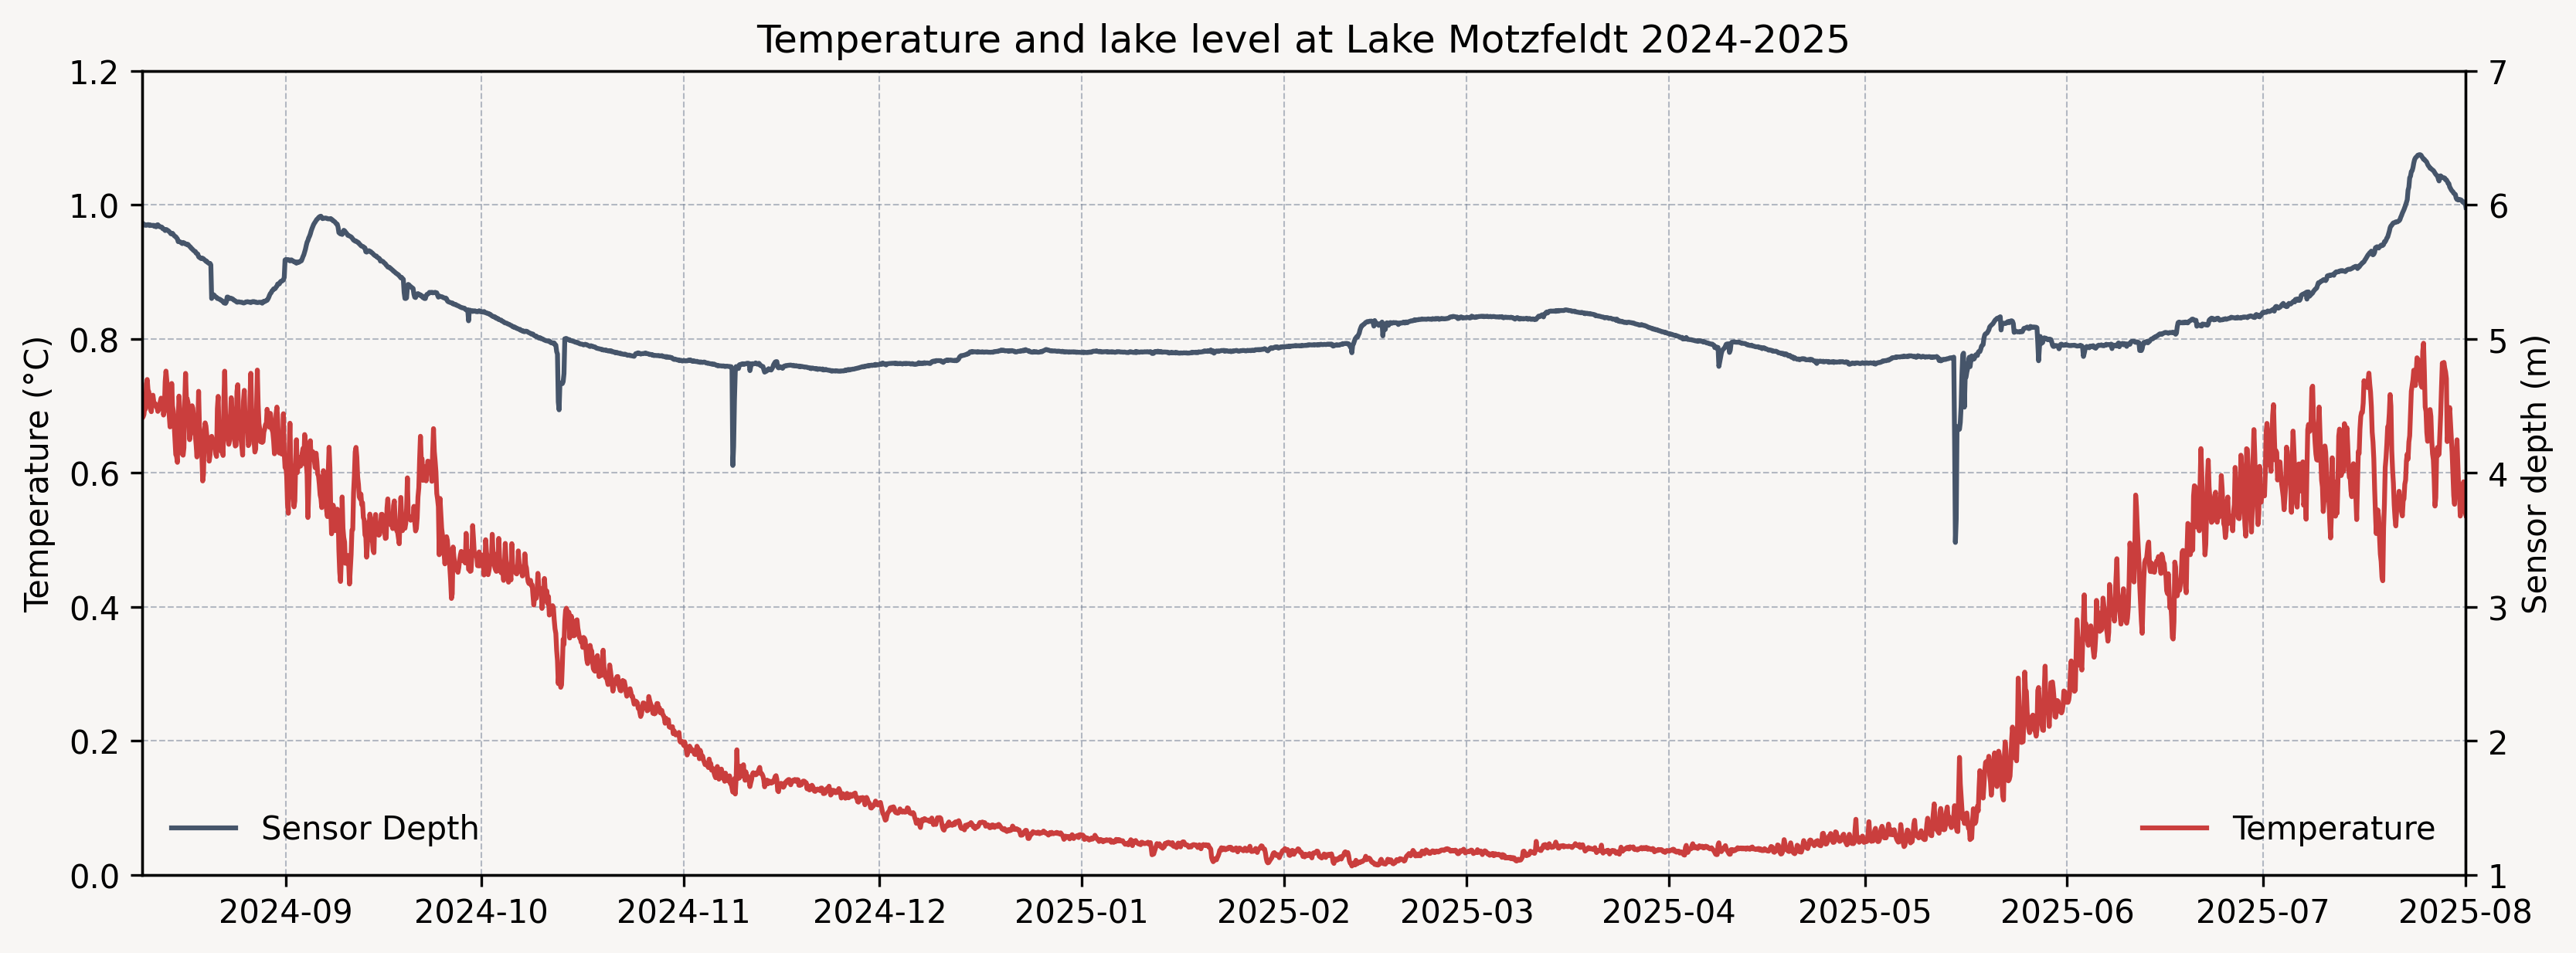

In [6]:
fig, (ax) = plt.subplots(figsize=(11, 4), dpi=300 , facecolor=background, layout="constrained")

# Background color
ax.set_facecolor(background)

ax.plot(df_rbr.temperature, color = lakecolor, label = 'Temperature')

ax2 = ax.twinx()
ax2.plot(df_rbr.Depth, color = marinecolor, label = 'Sensor Depth')

ax.set_xlim(date(2024, 8, 10), date(2025, 8, 1))
ax.set_ylim(1.2, 0)
ax2.set_ylim(1,7)
ax.invert_yaxis()  # Invert y-axis to have depth increasing downwards
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature and lake level at Lake Motzfeldt 2024-2025')
ax2.set_ylabel('Sensor depth (m)')
ax.legend(loc = 'lower right', frameon = False)
ax2.legend(loc = 'lower left', frameon = False)
ax.grid(color = lightmarine, linestyle = '--', linewidth = 0.5, alpha = 0.5)

plt.show()